In [1]:
import os
import numpy as np
import scipy
import scipy.stats as stats
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
import seaborn as sns

In [2]:
sns.set()

# Exercise session 6: WAIC

## WAIC Definition

Let us denote by $\Theta$ the samples $\theta_0, \theta_1, \dots, \theta_{S-1}$ in the trace and by $y$ the measurement(s). 

* The log-pointwise-predictive-density $\rm lppd$ is defined as:

$$ {\rm lppd}(y, \Theta) = \sum_i \log \frac{1}{S} \sum_s p(y_i | \Theta_s),$$

* The effective number of parameters $p_{{\rm waic}}$ is defined as:

$$ p_{{\rm waic}} = \sum_i {\rm var}_{\theta} \log p(y_i|\theta)$$

* The WAIC criterion (the lower, the better) is:

$${\rm WAIC}(y, \Theta) = -2(\rm{lppd} - p_{\rm waic}).$$

* The expected log pointwise predictive density $\rm{elpd}$ (the higher, the better) is defined as:

$$\rm{elpd} = (\rm{lppd} - p_{\rm waic}).$$

## WAIC for the beta-binomial

Let us implement and test the WAIC on the Beta-Binomial model: the *Hello World* probabilistic programming

We us consider a coin that falls heads with probability $\theta=0.25$ (assumed unknown). 

Our prior knowledge of $\theta$ is encoded in a Beta distributions with parameters $a=20$ and $b=10$:

$$ p_{\rm prior}(\theta) = \frac{1}{B(a,b)} \theta^{a-1} (1-\theta)^{b-1}, \qquad \theta \in [0, 1],$$

where $B(a,b)$ is a proper normalization constant such that $\int_{0}^1 p_{\rm prior}(\theta) \; d \theta = 1.$ 

We toss the coin $n$ times and measure a number $y$ of heads. How does our belief of $\theta$ change with the measurement?

In [3]:
a = 20 # prior: parameter a
b = 10 # prior: parameter b
n = 50 # likelihood: number of tosses
y = 15 # likelihood: number of HEADs observed. (Fixed in this example. It could be sampled form a binomial instead)

In [4]:
with pm.Model() as beta_binomial:
    theta = pm.Beta("theta", alpha=a, beta=b)
    y_obs = pm.Binomial("y_obs", n=n, p=theta, observed=y)
    trace_bb = pm.sample(1000, random_seed=123, return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [5]:
with beta_binomial:
    display(az.summary(trace_bb))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.439,0.053,0.338,0.54,0.001,0.001,1729.0,2713.0,1.0


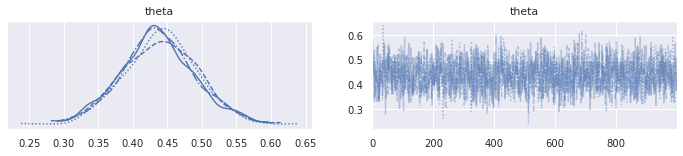

In [6]:
az.plot_trace(trace_bb);

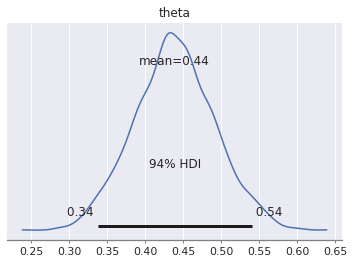

In [7]:
az.plot_posterior(trace_bb, color="b");

## WAIC computation details

Let us consider a scalar observation $y$ (as in the beta-binomial example). In the definitions above, the outer summations on $i$ disappear. 

Let us denote by ``lik_vec`` and ``loglik_vec`` vectors containing, respectively, the likelihood and log-likelihood of $y$, for the samples of $\theta_s \in \Theta$:

$$\text{loglik_vec} = [\log p(y | \theta_0)\;\; \log p(y | \theta_1),\;\; \dots,\;\; \log p(y | \theta_{S-1})]^\top$$
$$\text{lik_vec} = [p(y | \theta_0)\;\; p(y | \theta_1),\;\; \dots,\;\; p(y | \theta_{S-1})]^\top$$

* $p_{{\rm waic}}$ can be computed as the sample variance of ``loglik_vec``. In Python:

``p_waic = np.var(loglik_vec)``

* ${\rm lppd}$ could be computed (in principle) as the logarithm of the average of ``lik_vec``. In Python:

``lppd = np.log(np.mean(lik_vec))``

* For better numerical precision, ${\rm lppd}$ computation is typically worked out in the log-domain, exploiting the logsumexp trick:

``lppd = scipy.special.logsumexp(log_lik_vec) - np.log(S)``

This exploits the identity:

$$\log {{\sum_s p(y_i | \theta_s)}} =  \log\left(\sum_s e^{\log p(y_i | \theta_s)}\right),$$
where at the right-hand-side we recognize the ``logsumexp`` operation applied to the vector ``loglik_vec``.

Thus, in practice, all we need to compute the WAIC is the log-likelihood of the samples.

## WAIC manual computation

* Write the likelihood and the log-likelihood function of the observations in closed form. Note: for these calculations, we cannot disregard multiplicative/additive terms not depending on $\theta$.

The likelihood is:
$$p(y | \theta) = {{n}\choose{y}} \theta^{y} \cdot (1-\theta)^{n-y}.$$

The log-likelihood is:
$$\log p(y | \theta) = \log {{n}\choose{y}} + y \log(\theta) + (n-y)\log(1-\theta).$$

* Obtain the likelihood and the log-likelihood as python functions (including multiplicative/additive factors)

In [8]:
def lik(theta):
    return scipy.special.binom(n, y) * (theta ** y) * (1 - theta)**(n-y)

In [9]:
def log_lik(theta):
    return np.log(scipy.special.binom(n, y)) + y*np.log(theta) + (n-y)*np.log(1 - theta)

* Extract the samples $\Theta$ from the trace.

In [10]:
theta_trace = np.array(trace_bb.posterior.theta).ravel()
S = theta_trace.shape[0]

* Compute $\rm{lppd}$ and $p_{\rm waic}$

In [11]:
log_lik_vec = log_lik(theta_trace)
# log_lik_pm = np.array(trace_bb.log_likelihood.y_obs).ravel()

In [12]:
# lppd = np.log(np.mean(lik(theta_trace)))
lppd = scipy.special.logsumexp(log_lik_vec) - np.log(S) # sum is equivalent to logsumexp in log domain...

In [13]:
p_waic = np.var(log_lik_vec) # correct
p_waic

2.4212012918562396

* Compute $\rm{waic}$ and ${\rm elpd}$

In [14]:
waic = -2*(lppd - p_waic); waic

12.074935918139234

In [15]:
elpd = (lppd - p_waic); elpd

-6.037467959069617

## WAIC Computation with arviz

arviz computes these quantity automatically:

In [16]:
with beta_binomial:
    display(az.waic(trace_bb))

/home/marco/anaconda3/envs/bda/lib/python3.9/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/home/marco/anaconda3/envs/bda/lib/python3.9/site-packages/arviz/stats/stats.py:1677: UserWarning: The point-wise WAIC is the same with the sum WAIC, please double check
            the Observed RV in your model to make sure it returns element-wise logp.
            
  warnings.warn(


Computed from 4000 posterior samples and 1 observations log-likelihood matrix.

          Estimate       SE
elpd_waic    -6.04     0.00
p_waic        2.42        -

There has been a warning during the calculation. Please check the results.

## WAIC for the multiparameter model

In [17]:
y = np.loadtxt(os.path.join("..", "data", "chemical_shifts.txt"))
y

array([51.06, 55.12, 53.73, 50.24, 52.05, 56.4 , 48.45, 52.34, 55.65,
       51.49, 51.86, 63.43, 53.  , 56.09, 51.93, 52.31, 52.33, 57.48,
       57.44, 55.14, 53.93, 54.62, 56.09, 68.58, 51.36, 55.47, 50.73,
       51.94, 54.95, 50.39, 52.91, 51.5 , 52.68, 47.72, 49.73, 51.82,
       54.99, 52.84, 53.19, 54.52, 51.46, 53.73, 51.61, 49.81, 52.42,
       54.3 , 53.84, 53.16])

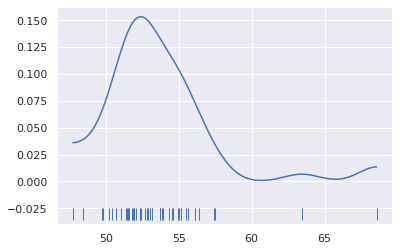

In [18]:
az.plot_kde(y, rug="True");

In [19]:
with pm.Model() as model_gaussian:
    mu = pm.Uniform('mu', lower=40, upper=70)
    sigma = pm.HalfNormal('sigma', sd=10)
    y_obs = pm.Normal('y_obs', mu=mu, sd=sigma, observed=y)
    trace_gaussian = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


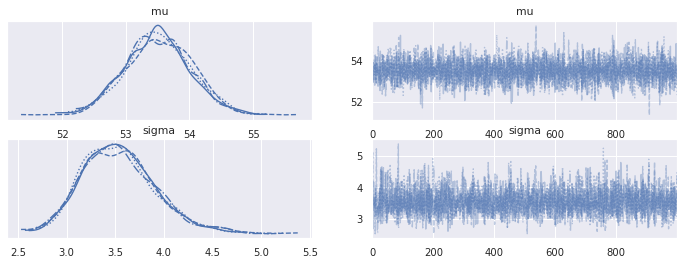

In [20]:
az.plot_trace(trace_gaussian);

In [21]:
with model_gaussian:
    display(az.summary(trace_gaussian))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,53.508,0.514,52.561,54.483,0.009,0.006,3562.0,2801.0,1.0
sigma,3.538,0.379,2.845,4.225,0.006,0.004,3591.0,2866.0,1.0


In [22]:
with model_gaussian:
    # select 500 samples <mu_s ,sigma_s> from the trace
    # for each samples, compute a draw N(mu_s ,sigma_s) 
    # The ppc variable is a dictionary, with the keys being the name of the observed variable in our model and the values an array of shape (samples, size). 
    # The dictionary allows dealing with models with more than one observed variable. 
    ppc = pm.sample_posterior_predictive(trace_gaussian, samples=500)

/home/marco/anaconda3/envs/bda/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


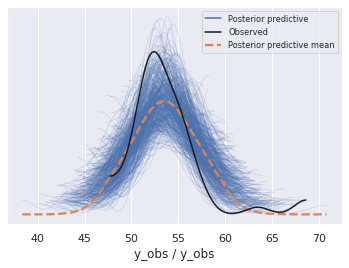

In [23]:
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model_gaussian));

The posterior predictive plot is not very convincing (outliers are not modeled)

In [24]:
with beta_binomial:
    display(az.waic(trace_gaussian))

/home/marco/anaconda3/envs/bda/lib/python3.9/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 posterior samples and 48 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -131.39    12.28
p_waic        5.41        -

There has been a warning during the calculation. Please check the results.

Let us compute the WAIC manually:

$$\mathcal{L}(\theta) = p(y | \theta) = \frac{1}{\sigma \sqrt{2 \pi}} e^{-\frac{(x-\mu)^2}{2\sigma^2}}$$

$$\mathcal{\ell}(\theta) = \log p(y|\theta) = -\log(\sigma) -\frac{1}{2} \log ({2 \pi}) - \frac{(x-\mu)^2}{2\sigma^2}$$

In [25]:
def log_lik(mu, sigma):
    pass

In [26]:
log_lik_vec = np.array(trace_gaussian.log_likelihood.y_obs)
log_lik_vec = log_lik_vec.reshape(-1, log_lik_vec.shape[-1]) # (mc sample, data sample)

In [27]:
log_lik_vec.shape

(4000, 48)

In [28]:
p_waic = np.var(log_lik_vec, axis=0, ddof=1) # correct
p_waic = np.sum(p_waic)
p_waic

5.415487429587396

In [29]:
lppd = scipy.special.logsumexp(log_lik_vec, axis=0) - np.log(S) # sum is equivalent to logsumexp in log domain...
lppd = np.sum(lppd)
lppd

-125.97156663853505

In [30]:
lppd - p_waic

-131.38705406812244